# Ban Luck - Using Reinforcement Learning to Squeeze your Relatives Dry

## What is Ban Luck?
In Southeast Asia (SEA), a Chinese New Year (CNY) tradition is to play Chinese Blackjack (Ban Luck) as a social activity. 

The game is as follows:

![How to Play?](assets/how_to_play.png "How to Play?")

**But you don't want to leave it down to luck, you want to "huat" (Be prosperous), so how do you squeeze every penny out of your relatives?**

## A typical strategy

### The Algorithm
As a player, when it is my turn, I follow the following algorithm:
```
Loop until Hold or Reveal:
  Let value = Hand value
  if value == 21 or value >= 17:
    Hold
  else:
    Draw
  if hand has 5 cards:
    Reveal
```

As a dealer, I would follow a similar algorithm but instead of holding, I would reveal hands.

Feels simple, and based on vibes, it seems sound!

### Benchmarking
But let's simulate some games with this algorithm and see how well it actually performs. 

For simplicity, 
- Everyone uses this algorithm.
- For all our runs unless otherwise stated, we will stick to 8 players (Including dealer).

In [3]:
from players import SimplePlayer
from dealer import SimpleDealer
from game import Game, make_deck
from simulation import run_game
import numpy as np
import matplotlib.pyplot as plt
from deck import SwooshShuffleStrategy

N_PLAYERS = 8 # Includes dealer
SIMULATIONS = 1000
# Exclude dealer
game = Game(n_players=N_PLAYERS - 1)

# rewards[i, j] is the reward for the j-th player in the i-th simulation
rewards = np.zeros((SIMULATIONS, N_PLAYERS))

deck = make_deck()
shuffle = SwooshShuffleStrategy()
for i in range(SIMULATIONS):
    shuffle.shuffle(deck) # Random shuffle
    # Simple is the strategy name for the algorithm we just described
    res = run_game(game, SimplePlayer(), SimpleDealer(), deck=deck)
    for j in range(N_PLAYERS):
        rewards[i, j] = res[j]
    game.soft_reset()


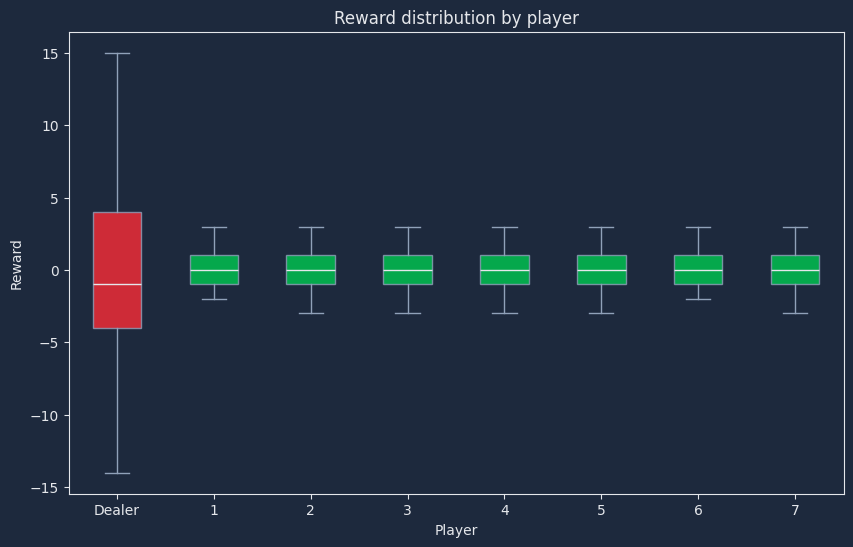

In [4]:
# Box plot: reward distribution for each player
COLOR_POSITIVE = "#00c950"
COLOR_NEGATIVE = "#fb2c36"
BG = "#1d293d"
LABELS = "#e5e7eb"
BORDER = "#90a1b9"

# One column per player: rewards[:, j] = all simulation rewards for player j
data_by_player = [rewards[:, j] for j in range(N_PLAYERS)]
medians = np.median(rewards, axis=0)
box_colors = [COLOR_POSITIVE if m >= 0 else COLOR_NEGATIVE for m in medians]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
bp = ax.boxplot(data_by_player, positions=range(N_PLAYERS), patch_artist=True)
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(BORDER)
    patch.set_alpha(0.8)
for item in bp["fliers"]:
    item.set_color(BORDER)
    item.set_markerfacecolor(BORDER)
    item.set_markeredgecolor(BORDER)
for el in ["whiskers", "caps"]:
    for item in bp[el]:
        item.set_color(BORDER)
for item in bp["medians"]:
    item.set_color(LABELS)

ax.set_xticks(range(N_PLAYERS))
ax.set_xticklabels(["Dealer"] + [str(i) for i in range(1, N_PLAYERS)], color=LABELS)
ax.set_xlabel("Player", color=LABELS)
ax.set_ylabel("Reward", color=LABELS)
ax.set_title("Reward distribution by player", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.show()

Some observations:
- Position of the players does not seem to matter
- Dealer seems to perform worse than players

Let's prove it!

### Verifying Position Does Not Matter

In [7]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM

# We will only analyze players (Excluding dealer)
data_by_player = [rewards[:, j] for j in range(1, N_PLAYERS)]
rows = []
for run in range(rewards.shape[0]):
    for player in range(1, N_PLAYERS):
        rows.append({"run": run, "player": player, "reward": rewards[run, player]})
df = pd.DataFrame(rows)

model = AnovaRM(data=df, depvar="reward", subject="run", within=["player"])
result = model.fit()
print("One-way repeated measures ANOVA: reward ~ player (subject = run)")
print(result.anova_table)

One-way repeated measures ANOVA: reward ~ player (subject = run)
         F Value  Num DF  Den DF    Pr > F
player  0.557636     6.0  5994.0  0.764333


Think of the `F Value` as how much `variability between rows (across players) / variability between columns (within a player) = 0.5578`, that is less variability between players than within players. There's a `76.4643%` chance of seeing this randomness purely by chance.

**TL;DR** There is no statistically detectable difference in rewards between seats. 

In [ ]:
# Consolidate mean across all rows in data_by_player (one value per run for players)
# Compare with dealer's mean using paired t test
import numpy as np
from scipy import stats

dealer_rewards = rewards[:, 0]  # shape (SIMULATIONS,)
# Per run: mean reward of all non-dealer players (so we have one value per run to pair with dealer)
players_mean_per_run = np.mean(rewards[:, 1:], axis=1)  # shape (SIMULATIONS,)
t_stat, p_value = stats.ttest_rel(dealer_rewards, players_mean_per_run)
print("Paired t-test (dealer vs mean-of-players per run):")
print(f"  t = {t_stat:.4f}, p = {p_value:.4f}")print(f"  Dealer mean = {np.mean(dealer_rewards):.4f}, Players (consolidated) mean = {np.mean(players_mean_per_run):.4f}")


Consolidated mean per seat (across all runs):
  Dealer: 0.0460
  Players (all non-dealer, pooled): -0.0066

Independent-samples t-test (dealer vs players):
  t = 0.6773, p = 0.4982


In [17]:
from agent import mc_control, policy_to_dict
import json

num_episodes = 1_000_000
epsilon = 0.1

print("Training Player agent (Monte Carlo control)...")
print(f"  n_players={N_PLAYERS}, agent_position=1, num_episodes={num_episodes}, epsilon={epsilon}")
Q, policy = mc_control(
    n_players=N_PLAYERS,
    agent_position=1,
    num_episodes=num_episodes,
    epsilon=epsilon,
)

policy_path = "policy.json"
policy = dict(sorted(policy.items(), key=lambda x: (len(x[0]), x[0])))
data = policy_to_dict(policy)
with open(policy_path, "w") as f:
    json.dump(data, f, indent=2)

Training Player agent (Monte Carlo control)...
  n_players=8, agent_position=1, num_episodes=1000000, epsilon=0.1
Episode 0 of 1000000 (0.0%)
Episode 100000 of 1000000 (10.0%)
Episode 200000 of 1000000 (20.0%)
Episode 300000 of 1000000 (30.0%)
Episode 400000 of 1000000 (40.0%)
Episode 500000 of 1000000 (50.0%)
Episode 600000 of 1000000 (60.0%)
Episode 700000 of 1000000 (70.0%)
Episode 800000 of 1000000 (80.0%)
Episode 900000 of 1000000 (90.0%)


Benchmark: 10000 games, 8 players (including dealer)

PolicyBasedPlayer (trained):
  Mean reward (per player): 0.0515
  Std dev:                  0.7575

SimplePlayer:
  Mean reward (per player): 0.0361
  Std dev:                  0.7945

--- Significance (paired) ---
  Mean difference (Policy − Simple): 0.0155
  95% CI: [-0.0060, 0.0370]
  Paired t-test: t = 1.4127, p = 0.1578


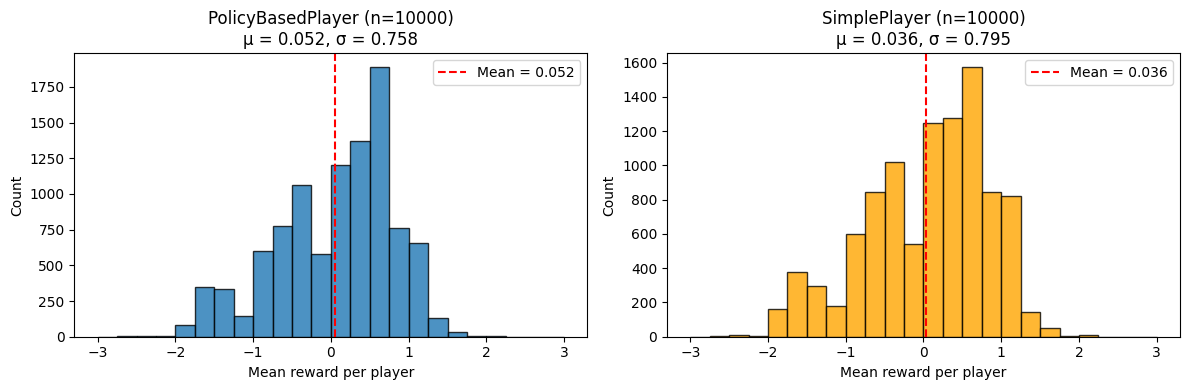

In [ ]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from game import Game, make_deck
from simulation import run_game
from players import SimplePlayer, PolicyBasedPlayer
from dealer import SimpleDealer
from agent import policy_from_dict
from deck import SwooshShuffleStrategy

BENCHMARK_RUNS = 10_000
policy_path = Path("policy.json")
if not policy_path.exists():
    raise FileNotFoundError(f"Policy not found: {policy_path}. Run the training cell above first.")

with open(policy_path) as f:
    policy = policy_from_dict(json.load(f))

policy_player = PolicyBasedPlayer(policy, epsilon=0.0)
simple_player = SimplePlayer()
dealer = SimpleDealer()
bench_game = Game(n_players=N_PLAYERS - 1)
shuffle = SwooshShuffleStrategy()
deck = make_deck()

rewards_policy_runs = np.zeros(BENCHMARK_RUNS)
rewards_simple_runs = np.zeros(BENCHMARK_RUNS)

cur_deck = deck.copy()
for run in range(BENCHMARK_RUNS):
    shuffle.shuffle(cur_deck)
    res_p = run_game(bench_game, policy_player, dealer, cur_deck)
    rewards_policy_runs[run] = np.mean(res_p[1:])
    bench_game.soft_reset()

cur_deck = deck.copy()
for run in range(BENCHMARK_RUNS):
    shuffle.shuffle(cur_deck)
    res_s = run_game(bench_game, simple_player, dealer, cur_deck)
    rewards_simple_runs[run] = np.mean(res_s[1:])
    bench_game.soft_reset()

mean_policy = np.mean(rewards_policy_runs)
mean_simple = np.mean(rewards_simple_runs)
std_policy = np.std(rewards_policy_runs, ddof=1)
std_simple = np.std(rewards_simple_runs, ddof=1)

print(f"Benchmark: {BENCHMARK_RUNS} games, {N_PLAYERS} players (including dealer)\n")
print("PolicyBasedPlayer (trained):")
print(f"  Mean reward (per player): {mean_policy:.4f}")
print(f"  Std dev:                  {std_policy:.4f}")
print("\nSimplePlayer:")
print(f"  Mean reward (per player): {mean_simple:.4f}")
print(f"  Std dev:                  {std_simple:.4f}")

mean_diff = mean_policy - mean_simple
if BENCHMARK_RUNS >= 2:
    t_stat, p_value = stats.ttest_rel(rewards_policy_runs, rewards_simple_runs)
    diffs = rewards_policy_runs - rewards_simple_runs
    std_diff = np.std(diffs, ddof=1)
    se_diff = std_diff / np.sqrt(BENCHMARK_RUNS)
    t_95 = 1.96 if BENCHMARK_RUNS > 30 else {2: 4.30, 5: 2.57, 10: 2.23, 20: 2.09, 30: 2.04}.get(BENCHMARK_RUNS, 2.0)
    ci_lo, ci_hi = mean_diff - t_95 * se_diff, mean_diff + t_95 * se_diff
    print("\n--- Significance (paired) ---")
    print(f"  Mean difference (Policy − Simple): {mean_diff:.4f}")
    print(f"  95% CI: [{ci_lo:.4f}, {ci_hi:.4f}]")
    print(f"  Paired t-test: t = {t_stat:.4f}, p = {p_value:.4f}")

# Histograms for both strategies
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
bin_edges = np.arange(-3, 3.25, 0.25)
axes[0].hist(rewards_policy_runs, bins=bin_edges, edgecolor="black", alpha=0.8)
axes[0].axvline(mean_policy, color="red", linestyle="--", label=f"Mean = {mean_policy:.3f}")
axes[0].set_xlabel("Mean reward per player")
axes[0].set_ylabel("Count")
axes[0].set_title(f"PolicyBasedPlayer (n={BENCHMARK_RUNS})\nμ = {mean_policy:.3f}, σ = {std_policy:.3f}")
axes[0].legend()

axes[1].hist(rewards_simple_runs, bins=bin_edges, edgecolor="black", alpha=0.8, color="orange")
axes[1].axvline(mean_simple, color="red", linestyle="--", label=f"Mean = {mean_simple:.3f}")
axes[1].set_xlabel("Mean reward per player")
axes[1].set_ylabel("Count")
axes[1].set_title(f"SimplePlayer (n={BENCHMARK_RUNS})\nμ = {mean_simple:.3f}, σ = {std_simple:.3f}")
axes[1].legend()
plt.tight_layout()
plt.show()